In [1]:
from __future__ import annotations
from pathlib import Path
from typing import Dict, Tuple, List
from typing import Iterable, Iterator, Optional, List
import os
import json
import pandas as pd
import numpy as np
from loguru import logger
import datetime as dt

In [4]:
import pandas as pd
from pathlib import Path

store = CoinDataStore("ETH")

start = pd.Timestamp("2025-01-01")
end   = pd.Timestamp("2025-08-31")


In [6]:
window=pd.Timedelta(minutes=10)
size_tol=0.01

# per-wallet rolling window: {'buy': deque[_Entry], 'sell': deque[_Entry]}
window_by_wallet: dict[int, dict[str, deque]] = defaultdict(lambda: {"buy": deque(), "sell": deque()})

out_records = []
tol_factor_low = 1.0 - size_tol
tol_factor_high = 1.0 + size_tol

def prune(wallet_id: int, now: pd.Timestamp):
    """Drop expired entries from the left of each deque (oldest first)."""
    cutoff = now - window
    for side in ("buy", "sell"):
        dq = window_by_wallet[wallet_id][side]
        while dq and dq[0].time < cutoff:
            dq.popleft()

            
    if not window_by_wallet[wallet_id]["buy"] and not window_by_wallet[wallet_id]["sell"]:
        window_by_wallet.pop(wallet_id, None)

def try_match(opposite_deque: deque[_Entry], new_size: float) -> _Entry | None:
    """
    Find the most recent alive opposite entry with size in [0.99, 1.01] * new_size.
    We scan from right (newest). Mark matched as not alive and return it.
    """
    lo = new_size * tol_factor_low
    hi = new_size * tol_factor_high
    # scan newest -> oldest
    for e in reversed(opposite_deque):
        if e.alive and lo <= e.size <= hi:
            e.alive = False
            return e
    return None

In [12]:
import pandas as pd
from pathlib import Path

store = CoinDataStore("ETH")

start = pd.Timestamp("2025-01-01")
end   = pd.Timestamp("2025-08-31")

df_wash = detect_wash_trades_streaming(
    store,
    window=pd.Timedelta(minutes=10),
    size_tol=0.01,
    start=start,
    end=end,
)

out_path = Path("out") / f"ETH_wash_{start.date()}_{end.date()}.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)
df_wash.to_parquet(out_path, index=False)
print(f"Found {len(df_wash):,} wash pairs → {out_path}")

Found 4,595,369 wash pairs → out/ETH_wash_2025-01-01_2025-08-31.parquet


In [13]:
df_wash

,wallet_id,t1,side1,price1,size1,t2,side2,price2,size2,delta_seconds,size_ratio
0,110,2025-03-22 10:50:23.052200940,sell,1996.199951,0.0100,2025-03-22 10:51:37.218626394,buy,1997.699951,0.0100,74.166428,1.000000
1,95,2025-03-22 10:51:08.482918570,sell,1997.199951,0.1502,2025-03-22 10:51:39.416259822,buy,1997.900024,0.1502,30.933340,1.000000
2,344,2025-03-22 10:51:41.632239124,sell,1998.000000,0.3099,2025-03-22 10:51:50.846517364,buy,1997.900024,0.3075,9.214278,0.992256
3,110,2025-03-22 10:51:37.218626394,buy,1997.599976,0.0100,2025-03-22 10:52:02.615234610,sell,1997.599976,0.0100,25.396608,1.000000
4,95,2025-03-22 10:53:48.452170250,sell,1997.400024,0.1503,2025-03-22 10:53:57.006423545,buy,1996.099976,0.1503,8.554253,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
4595364,48723,2025-07-27 08:37:01.546000000,buy,3769.300049,0.0042,2025-07-27 08:43:49.450000000,sell,3774.000000,0.0042,407.903992,1.000000
4595365,48739,2025-07-27 08:34:51.347000000,buy,3769.500000,0.0132,2025-07-27 08:44:09.584000000,sell,3774.100098,0.0132,558.237000,1.000000
4595366,48739,2025-07-27 08:34:51.347000000,buy,3769.100098,0.0132,2025-07-27 08:44:23.202000000,sell,3774.199951,0.0132,571.854980,1.000000
4595367,48739,2025-07-27 08:34:51.347000000,buy,3769.399902,0.0132,2025-07-27 08:44:23.202000000,sell,3774.300049,0.0132,571.854980,1.000000


In [16]:
df_wash.describe()

,wallet_id,t1,price1,size1,t2,price2,size2,delta_seconds,size_ratio
count,4.595369e+06,4595369,4.595369e+06,4.595369e+06,4595369,4.595369e+06,4.595369e+06,4.595369e+06,4.595369e+06
mean,1.101405e+04,2025-06-02 13:06:35.053560064,2.523695e+03,4.045022e+00,2025-06-02 13:09:42.667118336,2.523735e+03,4.045063e+00,1.876135e+02,9.999930e-01
min,1.000000e+00,2025-03-22 10:50:23.052200940,1.382500e+03,1.000000e-04,2025-03-22 10:51:37.218626394,1.382500e+03,1.000000e-04,0.000000e+00,9.900990e-01
25%,4.760000e+02,2025-05-07 18:23:10.254491904,2.040000e+03,8.440000e-02,2025-05-07 18:30:57.760036608,2.041600e+03,8.440000e-02,3.851100e+01,1.000000e+00
50%,1.267000e+03,2025-06-05 16:15:39.055000064,2.522000e+03,4.100000e-01,2025-06-05 16:17:48.868999936,2.522000e+03,4.100000e-01,1.314150e+02,1.000000e+00
75%,6.668000e+03,2025-07-09 18:12:29.457999872,2.778600e+03,2.900000e+00,2025-07-09 18:13:53.136999936,2.778300e+03,2.900000e+00,3.092760e+02,1.000000e+00
max,2.289570e+05,2025-07-27 08:41:22.363000,3.862600e+03,1.200000e+03,2025-07-27 08:44:25.071000,3.862600e+03,1.200000e+03,6.000000e+02,1.010101e+00
std,2.271672e+04,NaN,6.199734e+02,1.367398e+01,NaN,6.199963e+02,1.367444e+01,1.717635e+02,3.237149e-03


In [17]:
df_wash[df_wash["size1"] == df_wash["size1"].max()]

,wallet_id,t1,side1,price1,size1,t2,side2,price2,size2,delta_seconds,size_ratio
2052859,20195,2025-05-28 10:03:05.414,buy,2616.800049,1200.0,2025-05-28 10:03:08.607,sell,2600.0,1200.0,3.193,1.0


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---- point here ----
IN = Path("out/ETH_wash_2025-01-01_2025-08-31.parquet")   # or your path

def load_dfwash(path: Path) -> pd.DataFrame:
    df = (pd.read_parquet(path) if path.suffix==".parquet" else pd.read_csv(path))
    # enforce cheap dtypes
    cast = {
        "wallet_id": "uint32",
        "price1": "float32", "size1": "float32",
        "price2": "float32", "size2": "float32",
        "delta_seconds": "float32", "size_ratio": "float32",
    }
    for c, dt in cast.items():
        if c in df: df[c] = df[c].astype(dt, copy=False)
    for c in ("t1","t2"):
        if c in df and not np.issubdtype(df[c].dtype, np.datetime64):
            df[c] = pd.to_datetime(df[c], errors="coerce")
    # derived columns
    df["direction"] = (df["side1"].astype("string") + "->" + df["side2"].astype("string")).astype("category")
    df["dt_s"] = df["delta_seconds"].astype("float32")
    df["size_err_pct"] = (df["size_ratio"] - 1.0).abs() * 100.0
    df["price_change_pct"] = ((df["price2"] - df["price1"]) / df["price1"].clip(lower=1e-12)).astype("float32")
    df["abs_price_change_bps"] = (df["price_change_pct"].abs() * 1e4).astype("float32")
    df["date"] = df["t1"].dt.date
    df["hour"] = df["t1"].dt.hour.astype("int16")
    # “same price” within tiny tolerance; adjust if your tick size differs
    df["same_price"] = (df["price2"] - df["price1"]).abs() <= 1e-8
    return df

DFWash = load_dfwash(IN)

In [2]:
DFWash

,wallet_id,t1,side1,price1,size1,t2,side2,price2,size2,delta_seconds,size_ratio,direction,dt_s,size_err_pct,price_change_pct,abs_price_change_bps,date,hour,same_price
0,110,2025-03-22 10:50:23.052200940,sell,1996.199951,0.0100,2025-03-22 10:51:37.218626394,buy,1997.699951,0.0100,74.166428,1.000000,sell->buy,74.166428,0.000000,0.000751,7.514277,2025-03-22,10,False
1,95,2025-03-22 10:51:08.482918570,sell,1997.199951,0.1502,2025-03-22 10:51:39.416259822,buy,1997.900024,0.1502,30.933340,1.000000,sell->buy,30.933340,0.000000,0.000351,3.505274,2025-03-22,10,False
2,344,2025-03-22 10:51:41.632239124,sell,1998.000000,0.3099,2025-03-22 10:51:50.846517364,buy,1997.900024,0.3075,9.214278,0.992256,sell->buy,9.214278,0.774437,-0.000050,0.500378,2025-03-22,10,False
3,110,2025-03-22 10:51:37.218626394,buy,1997.599976,0.0100,2025-03-22 10:52:02.615234610,sell,1997.599976,0.0100,25.396608,1.000000,buy->sell,25.396608,0.000000,0.000000,0.000000,2025-03-22,10,True
4,95,2025-03-22 10:53:48.452170250,sell,1997.400024,0.1503,2025-03-22 10:53:57.006423545,buy,1996.099976,0.1503,8.554253,1.000000,sell->buy,8.554253,0.000000,-0.000651,6.508706,2025-03-22,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595364,48723,2025-07-27 08:37:01.546000000,buy,3769.300049,0.0042,2025-07-27 08:43:49.450000000,sell,3774.000000,0.0042,407.903992,1.000000,buy->sell,407.903992,0.000000,0.001247,12.469028,2025-07-27,8,False
4595365,48739,2025-07-27 08:34:51.347000000,buy,3769.500000,0.0132,2025-07-27 08:44:09.584000000,sell,3774.100098,0.0132,558.237000,1.000000,buy->sell,558.237000,0.000000,0.001220,12.203469,2025-07-27,8,False
4595366,48739,2025-07-27 08:34:51.347000000,buy,3769.100098,0.0132,2025-07-27 08:44:23.202000000,sell,3774.199951,0.0132,571.854980,1.000000,buy->sell,571.854980,0.000000,0.001353,13.530693,2025-07-27,8,False
4595367,48739,2025-07-27 08:34:51.347000000,buy,3769.399902,0.0132,2025-07-27 08:44:23.202000000,sell,3774.300049,0.0132,571.854980,1.000000,buy->sell,571.854980,0.000000,0.001300,12.999805,2025-07-27,8,False


In [21]:
def global_snapshot(df: pd.DataFrame) -> dict:
    out = {}
    out["pairs"] = len(df)
    out["unique_wallets"] = df["wallet_id"].nunique()
    out["span"] = (df["t1"].min(), df["t2"].max())
    out["direction_counts"] = df["direction"].value_counts().to_dict()
    # time gap distribution
    q_dt = df["dt_s"].quantile([0.25,0.5,0.75,0.9,0.99]).round(2).to_dict()
    out["delta_seconds_quantiles"] = q_dt
    out["<=60s_share"] = float((df["dt_s"] <= 60).mean())
    out["<=300s_share"] = float((df["dt_s"] <= 300).mean())
    # size matching tightness
    out["size_err_pct_quantiles"] = df["size_err_pct"].quantile([0.5,0.9,0.99]).round(3).to_dict()
    out["same_price_share"] = float(df["same_price"].mean())
    # concentration
    top10 = df["wallet_id"].value_counts().nlargest(10)
    out["top10_share"] = float(top10.sum() / len(df)) if len(df) else 0.0
    return out

snap = global_snapshot(DFWash)
snap

{'pairs': 4595369,
 'unique_wallets': 29388,
 'span': (Timestamp('2025-03-22 10:50:23.052200940'),
  Timestamp('2025-07-27 08:44:25.071000')),
 'direction_counts': {'buy->sell': 2312423, 'sell->buy': 2282946},
 'delta_seconds_quantiles': {0.25: 38.51,
  0.5: 131.41,
  0.75: 309.28,
  0.9: 467.95,
  0.99: 585.67},
 '<=60s_share': 0.3275717358061997,
 '<=300s_share': 0.7394059106026089,
 'size_err_pct_quantiles': {0.5: 0.0, 0.9: 0.643, 0.99: 0.967},
 'same_price_share': 0.014495680325127318,
 'top10_share': 0.23923671853119957}

In [27]:
def per_wallet_leaderboard(df: pd.DataFrame, top: int = 50) -> pd.DataFrame:
    # choose a notion of "wash volume" (min of sizes is conservative)
    wash_vol = np.minimum(df["size1"], df["size2"]).astype("float32")
    grp = df.assign(wash_vol=wash_vol).groupby("wallet_id", sort=False)

    agg = grp.agg(
        n_pairs=("wallet_id","size"),
        first_time=("t1","min"),
        last_time=("t2","max"),
        active_days=("date", lambda s: s.nunique()),
        wash_volume=("wash_vol","sum"),
        median_dt_s=("dt_s","median"),
        q90_dt_s=("dt_s", lambda s: s.quantile(0.9)),
        median_size_err_pct=("size_err_pct","median"),
        same_price_share=("same_price","mean"),
        mean_abs_price_bps=("abs_price_change_bps","mean")
    ).reset_index()

    # direction balance: how symmetric is buy->sell vs sell->buy
    dir_counts = df.pivot_table(index="wallet_id", columns="direction", values="t1", aggfunc="size", fill_value=0)
    for col in ("buy->sell","sell->buy"):
        if col not in dir_counts.columns: dir_counts[col] = 0
    dir_counts["dir_balance"] = (dir_counts["buy->sell"] - dir_counts["sell->buy"]).abs() / \
                                (dir_counts["buy->sell"] + dir_counts["sell->buy"]).clip(lower=1)
    out = agg.merge(dir_counts[["dir_balance"]].reset_index(), on="wallet_id", how="left")

    out = out.sort_values(["wash_volume", "n_pairs"], ascending=[False, False])
    
    out["n_pairs"] = out["n_pairs"].astype("uint32")
    out["wash_volume"] = out["wash_volume"].astype("float32")
    out["median_dt_s"] = out["median_dt_s"].astype("float32")
    out["q90_dt_s"] = out["q90_dt_s"].astype("float32")
    out["median_size_err_pct"] = out["median_size_err_pct"].astype("float32")
    out["same_price_share"] = out["same_price_share"].astype("float32")
    return out.head(top)

leaderboard = per_wallet_leaderboard(DFWash, top=50)
leaderboard.head(10)

/tmp/ipykernel_8326/2029368165.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dir_counts = df.pivot_table(index="wallet_id", columns="direction", values="t1", aggfunc="size", fill_value=0)


,wallet_id,n_pairs,first_time,last_time,active_days,wash_volume,median_dt_s,q90_dt_s,median_size_err_pct,same_price_share,mean_abs_price_bps,dir_balance
5112,6668,154020,2025-04-14 13:32:06.677986483,2025-07-27 08:41:22.363,67,1.947684e+06,177.722000,494.939392,0.245470,0.007220,26.122244,0.017842
12,548,156818,2025-03-22 11:01:09.842533340,2025-07-27 07:57:16.102,123,1.139163e+06,215.841934,508.130005,0.285292,0.008322,24.683336,0.006071
29,826,180134,2025-03-22 11:14:23.285121311,2025-07-27 07:57:14.960,128,1.116897e+06,167.608124,486.049622,0.160551,0.009299,21.753311,0.001510
44,48,42743,2025-03-22 11:27:43.523408271,2025-06-05 16:12:34.008,63,6.982806e+05,160.273102,484.231415,0.155056,0.007370,41.523979,0.020144
82,644,27454,2025-03-22 12:54:54.785118905,2025-07-27 07:37:57.597,128,4.472843e+05,74.817497,431.915131,0.152251,0.025971,19.993061,0.035405
57,1013,18658,2025-03-22 11:56:35.354935390,2025-07-17 15:30:50.163,98,4.248265e+05,190.074249,495.499023,0.154501,0.009594,32.025726,0.001394
129,15,16355,2025-03-22 14:33:26.867483325,2025-07-27 08:19:31.107,123,4.097415e+05,185.309006,494.015961,0.162822,0.007093,23.144094,0.031122
47,123,6789,2025-03-22 11:27:35.680070155,2025-07-27 07:06:50.566,128,3.697056e+05,193.705414,485.354401,0.071895,0.007807,23.377409,0.003977
32,38,35274,2025-03-22 11:14:17.662514673,2025-07-27 08:04:12.721,128,3.418789e+05,244.225006,521.587708,0.411999,0.010461,21.302568,0.009015
14551,6569,58983,2025-06-02 21:46:55.009000000,2025-07-27 08:37:36.161,56,2.878944e+05,131.119003,464.356995,0.114858,0.008223,24.215775,0.014733


In [35]:
# ======================= DFWash plotting toolkit =======================
# Requirements: pandas, numpy, matplotlib. No seaborn. One-figure-per-plot.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --------- helpers: load + derive columns (idempotent) ----------
def load_dfwash(path_or_df):
    if isinstance(path_or_df, (str, Path)):
        path = Path(path_or_df)
        df = pd.read_parquet(path) if path.suffix == ".parquet" else pd.read_csv(path)
    else:
        df = path_or_df.copy()

    # enforce lightweight dtypes (if columns exist)
    cast = {
        "wallet_id": "uint32",
        "price1": "float32", "size1": "float32",
        "price2": "float32", "size2": "float32",
        "delta_seconds": "float32", "size_ratio": "float32",
    }
    for c, dt in cast.items():
        if c in df.columns:
            try:
                df[c] = df[c].astype(dt, copy=False)
            except Exception:
                pass

    # datetimes
    for c in ("t1", "t2"):
        if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
            df[c] = pd.to_datetime(df[c], errors="coerce")

    # derived
    if "side1" in df and "side2" in df:
        df["direction"] = (df["side1"].astype("string") + "->" + df["side2"].astype("string")).astype("category")
    if "delta_seconds" in df:
        df["dt_s"] = df["delta_seconds"].astype("float32")
    if "size_ratio" in df:
        df["size_err_pct"] = (df["size_ratio"] - 1.0).abs().astype("float32") * 100.0
    if {"price1","price2"} <= set(df.columns):
        base = df["price1"].replace(0, np.nan)
        df["price_change_pct"] = ((df["price2"] - df["price1"]) / base).astype("float32")
        df["abs_price_change_bps"] = (df["price_change_pct"].abs() * 1e4).astype("float32")
        df["same_price"] = (df["price2"] - df["price1"]).abs() <= 1e-8
    if "t1" in df:
        df["date"] = df["t1"].dt.date
        df["hour"] = df["t1"].dt.hour.astype("int16")
        df["dow"] = df["t1"].dt.dayofweek.astype("int8")  # 0=Mon
    return df

# --------- core plotting functions (each creates its own figure) ----------
def plot_pairs_by_hour(df, out_dir=None, show=False):
    counts = df.groupby("hour").size().reindex(range(24), fill_value=0)
    plt.figure(figsize=(8,4))
    counts.plot(kind="bar")
    plt.title("Wash pairs by hour (UTC)")
    plt.xlabel("Hour of day")
    plt.ylabel("Pairs")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "pairs_by_hour.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_pairs_by_dow(df, out_dir=None, show=False):
    counts = df.groupby("dow").size().reindex(range(7), fill_value=0)
    plt.figure(figsize=(7,4))
    counts.plot(kind="bar")
    plt.title("Wash pairs by day of week (0=Mon)")
    plt.xlabel("Day of week")
    plt.ylabel("Pairs")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "pairs_by_dow.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_delta_seconds_hist(df, out_dir=None, show=False):
    x = df["dt_s"].dropna().to_numpy()
    plt.figure(figsize=(8,4))
    # wide bins but capped for readability
    bins = min(200, max(20, int(np.sqrt(max(len(x),1)))))
    plt.hist(x, bins=bins)
    plt.title("Round-trip time (seconds)")
    plt.xlabel("Δt (seconds)")
    plt.ylabel("Count")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "delta_seconds_hist.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_size_error_hist(df, out_dir=None, show=False):
    x = df["size_err_pct"].dropna().to_numpy()
    plt.figure(figsize=(8,4))
    bins = min(200, max(20, int(np.sqrt(max(len(x),1)))))
    plt.hist(x, bins=bins)
    plt.title("Size matching error (%)")
    plt.xlabel("|size2/size1 - 1| × 100%")
    plt.ylabel("Count")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "size_error_pct_hist.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_price_change_bps_hist(df, out_dir=None, show=False):
    x = df["abs_price_change_bps"].dropna().to_numpy()
    plt.figure(figsize=(8,4))
    bins = min(200, max(20, int(np.sqrt(max(len(x),1)))))
    plt.hist(x, bins=bins)
    plt.title("Absolute price change per pair (bps)")
    plt.xlabel("|Δprice / price1| × 10,000")
    plt.ylabel("Count")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "abs_price_change_bps_hist.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_size_vs_dt_scatter(df, sample=200_000, out_dir=None, show=False):
    # For very large sets, downsample for plotting speed
    d = df[["dt_s","size1","size2"]].dropna()
    if len(d) > sample:
        d = d.sample(sample, random_state=42)
    # use min(size1, size2) as conservative "wash size"
    s = np.minimum(d["size1"].to_numpy(), d["size2"].to_numpy())
    x = d["dt_s"].to_numpy()
    plt.figure(figsize=(7.5,5))
    plt.scatter(x, s, s=None, alpha=0.3, edgecolors="none")
    plt.title("Wash size vs. round-trip time")
    plt.xlabel("Δt (seconds)")
    plt.ylabel("min(size1, size2)")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "size_vs_dt_scatter.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_cumulative_pairs(df, out_dir=None, show=False):
    if "t1" not in df: return
    ts = (df.sort_values("t1")
            .assign(n=1)
            .set_index("t1")["n"]
            .resample("1H").sum().fillna(0).cumsum())
    plt.figure(figsize=(8,4))
    plt.plot(ts.index, ts.values)
    plt.title("Cumulative wash pairs over time (hourly res.)")
    plt.xlabel("Time")
    plt.ylabel("Cumulative pairs")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / "cumulative_pairs.png", dpi=150)
    if show: plt.show()
    plt.close()

def plot_top_wallets(df, metric="n_pairs", top=20, out_dir=None, show=False):
    # metric: "n_pairs" or "wash_volume"
    wash_vol = np.minimum(df["size1"], df["size2"]).astype("float32")
    if metric == "wash_volume":
        s = df.assign(wash_vol=wash_vol).groupby("wallet_id")["wash_vol"].sum()
        title = f"Top {top} wallets by wash volume"
        ylabel = "Sum min(size1,size2)"
        fname = f"top_wallets_by_volume_top{top}.png"
    else:
        s = df.groupby("wallet_id").size()
        title = f"Top {top} wallets by number of pairs"
        ylabel = "Pairs"
        fname = f"top_wallets_by_pairs_top{top}.png"

    s = s.sort_values(ascending=False).head(top)
    plt.figure(figsize=(10,5))
    s.plot(kind="bar")
    plt.title(title)
    plt.xlabel("wallet_id")
    plt.ylabel(ylabel)
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / fname, dpi=150)
    if show: plt.show()
    plt.close()

def plot_same_price_share_top_wallets(df, top=20, out_dir=None, show=False):
    s = (df.groupby("wallet_id")["same_price"].mean()
           .sort_values(ascending=False)
           .head(top))
    plt.figure(figsize=(10,5))
    s.plot(kind="bar")
    plt.title(f"Top {top} wallets by same-price share")
    plt.xlabel("wallet_id")
    plt.ylabel("Share of pairs with identical price")
    plt.tight_layout()
    if out_dir: plt.savefig(Path(out_dir) / f"top_wallets_same_price_share_top{top}.png", dpi=150)
    if show: plt.show()
    plt.close()

# --------- one-shot driver ----------
def make_dfwash_plots(path_or_df, out_dir="plots_dfwash", show=False, top_wallets=20):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    df = load_dfwash(path_or_df)

    # guard: nothing to plot
    if df.empty:
        print("DFWash is empty—no plots produced.")
        return

    plot_pairs_by_hour(df, out_dir, show)
    plot_pairs_by_dow(df, out_dir, show)

    plot_delta_seconds_hist(df, out_dir, show)
    plot_delta_seconds_ecdf(df, out_dir, show)
    plot_size_error_hist(df, out_dir, show)
    plot_price_change_bps_hist(df, out_dir, show)
    plot_size_vs_dt_scatter(df, out_dir=out_dir, show=show)
    plot_cumulative_pairs(df, out_dir, show)
    plot_top_wallets(df, metric="n_pairs", top=top_wallets, out_dir=out_dir, show=show)
    plot_top_wallets(df, metric="wash_volume", top=top_wallets, out_dir=out_dir, show=show)
    plot_same_price_share_top_wallets(df, top=top_wallets, out_dir=out_dir, show=show)

    print(f"Saved plots to: {out_dir.resolve()}")
# ===================== end toolkit =====================

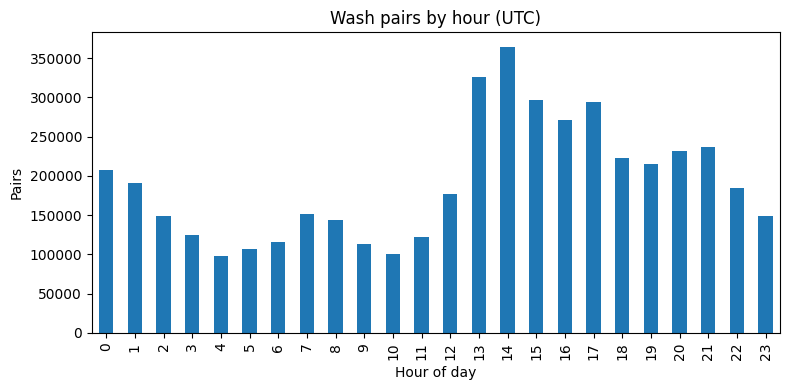

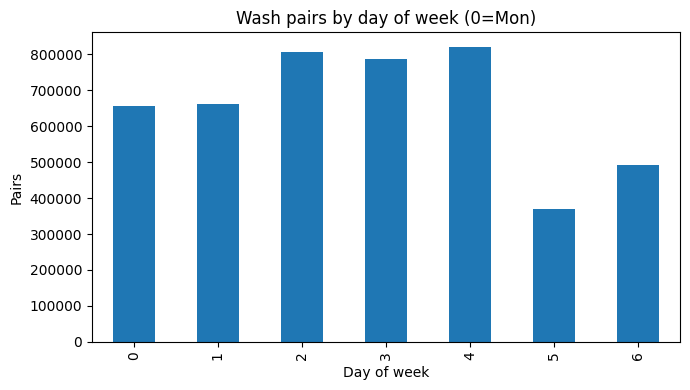

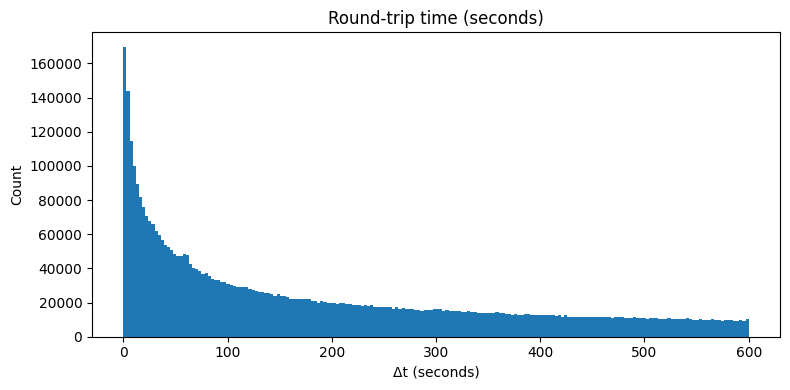

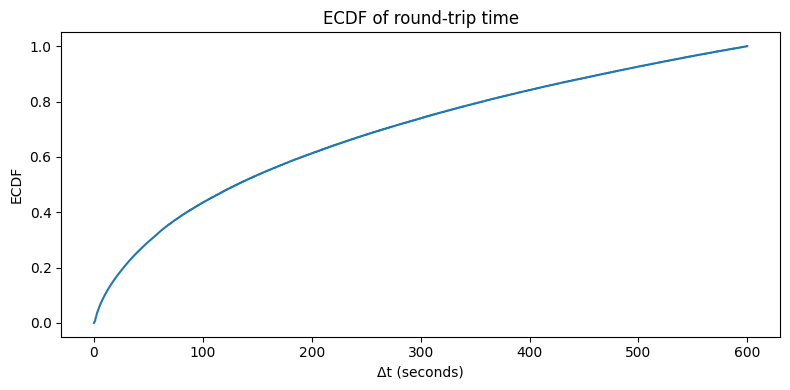

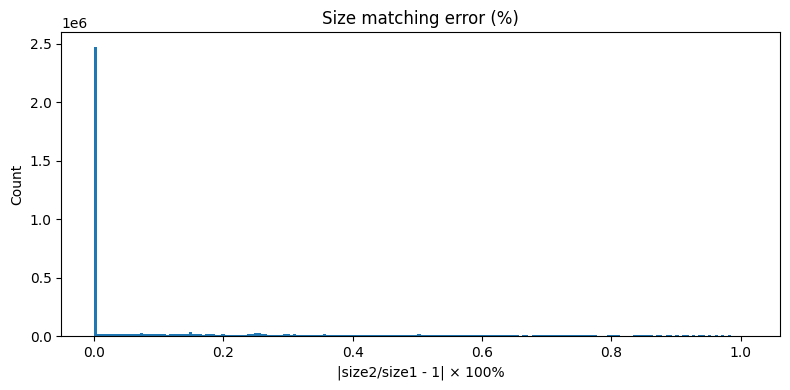

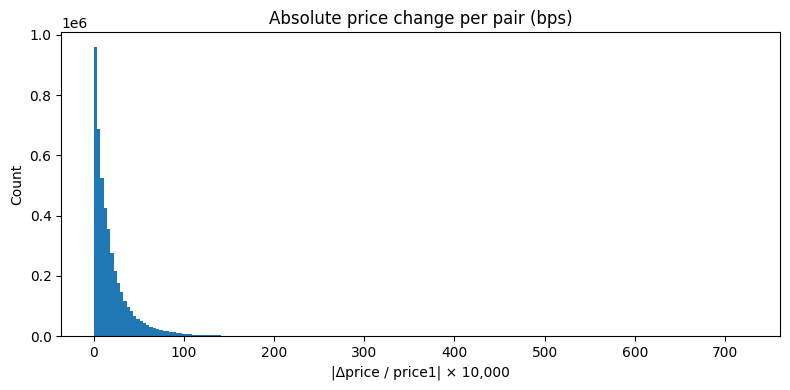

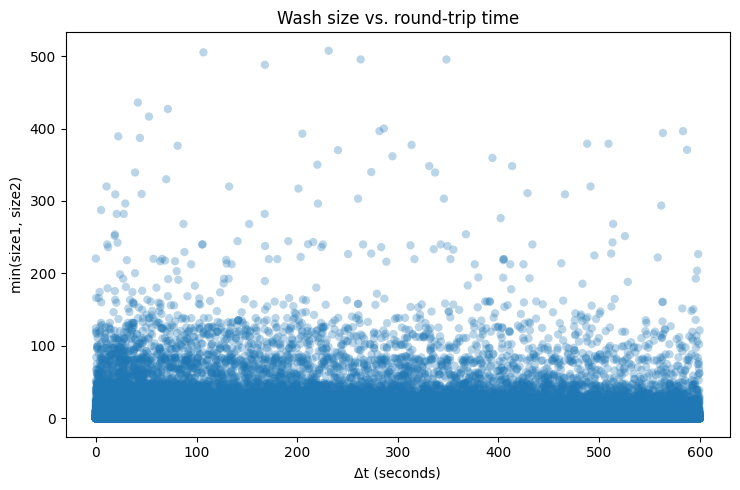

/tmp/ipykernel_8326/1475191110.py:157: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").sum().fillna(0).cumsum())


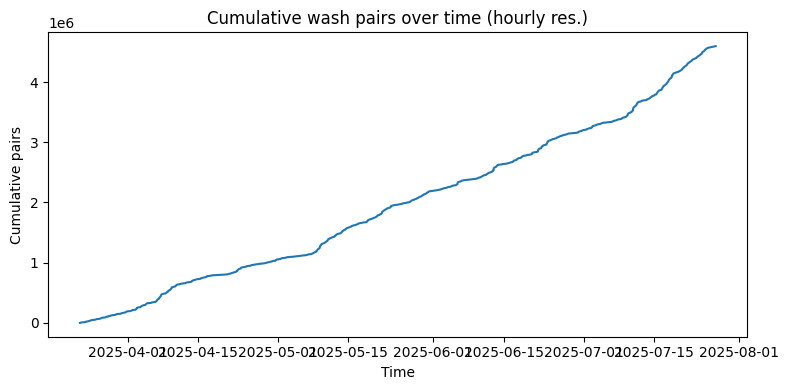

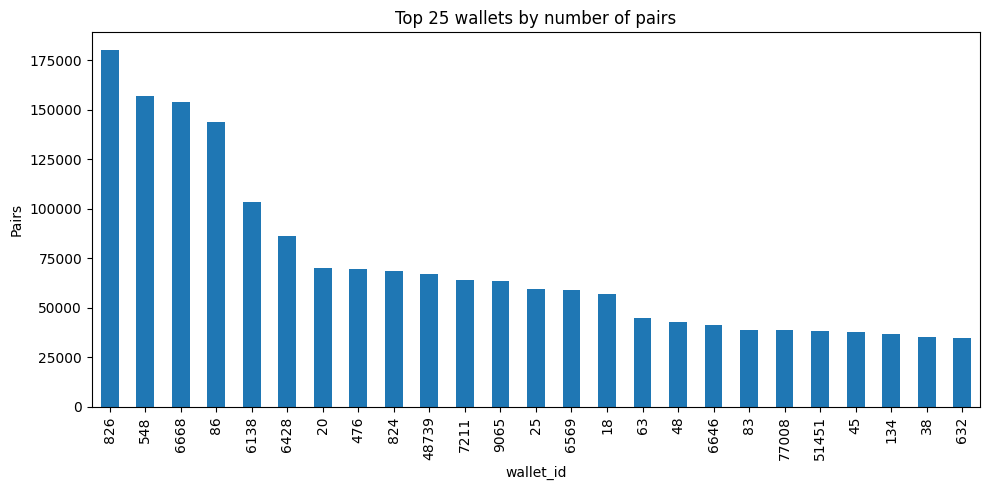

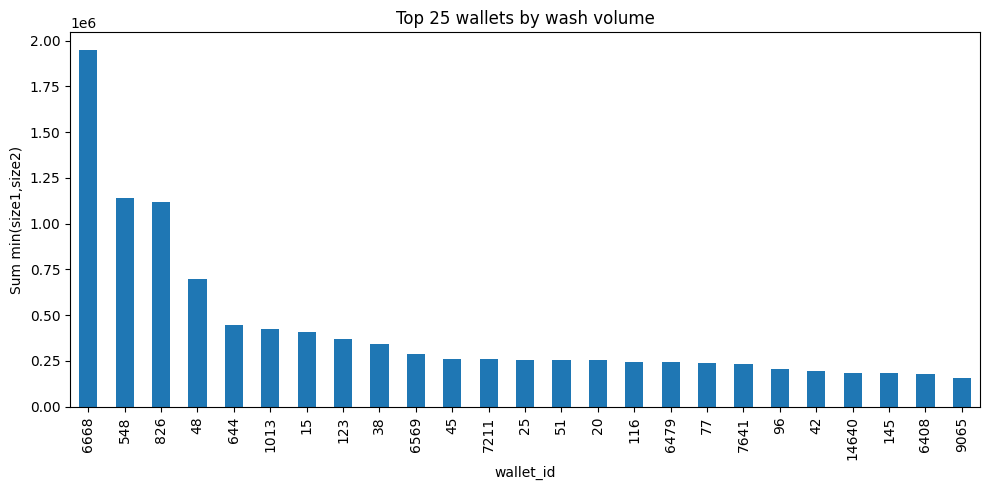

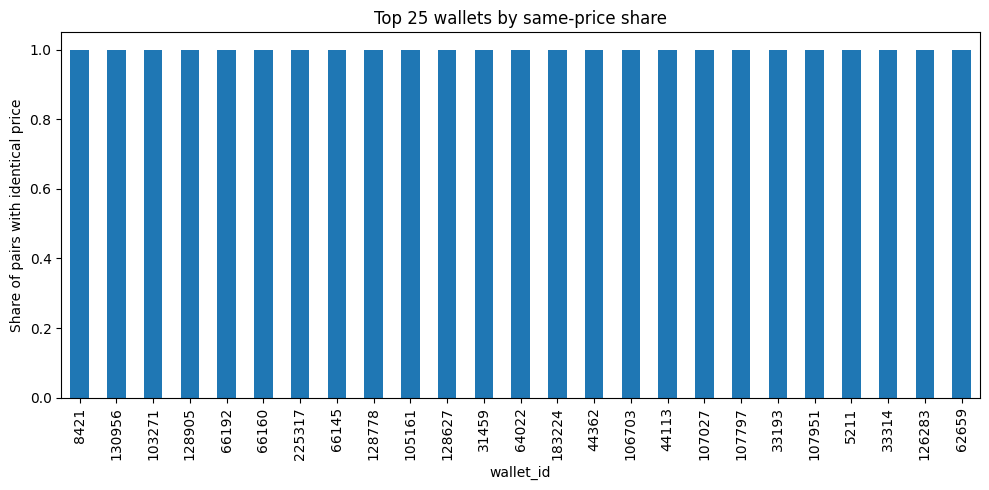

Saved plots to: /home/debian/Hyperliquid_Wash_Trading_detection/plots_dfwash_ETH


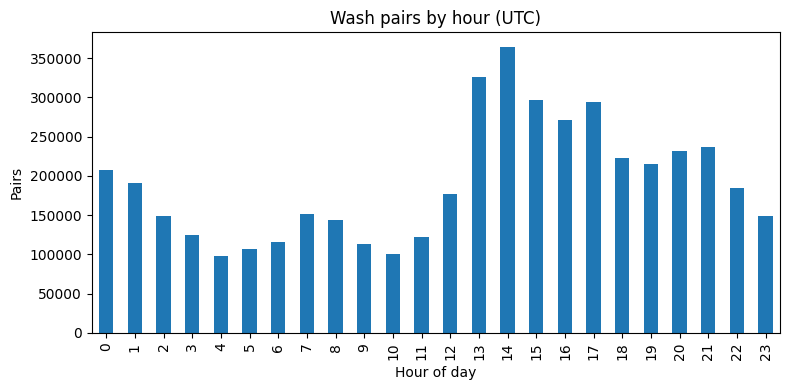

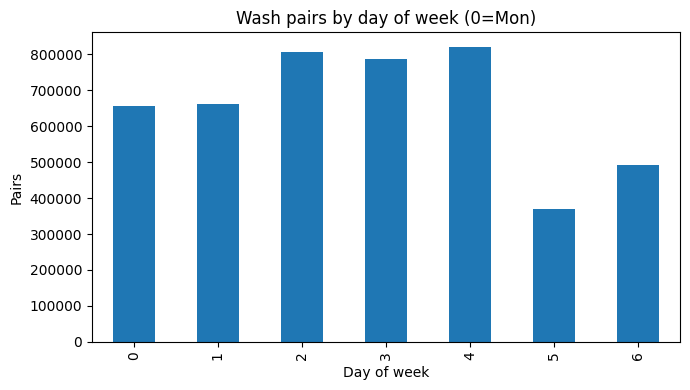

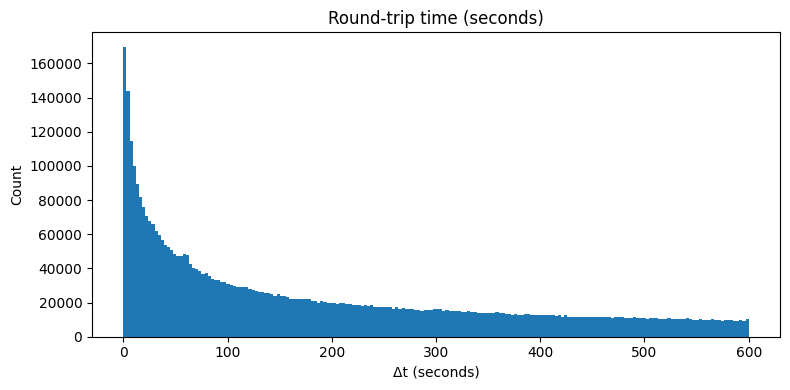

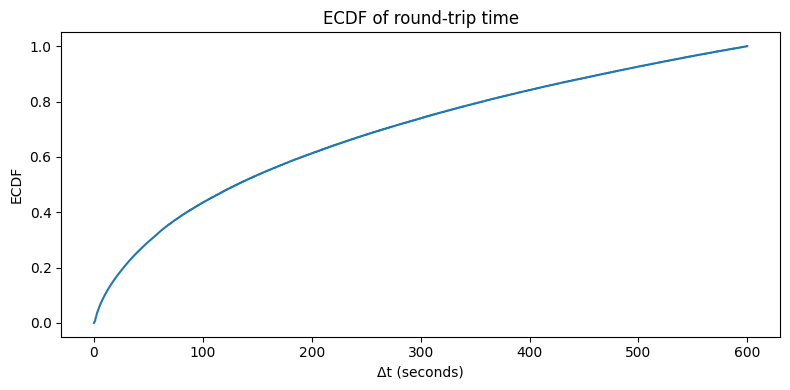

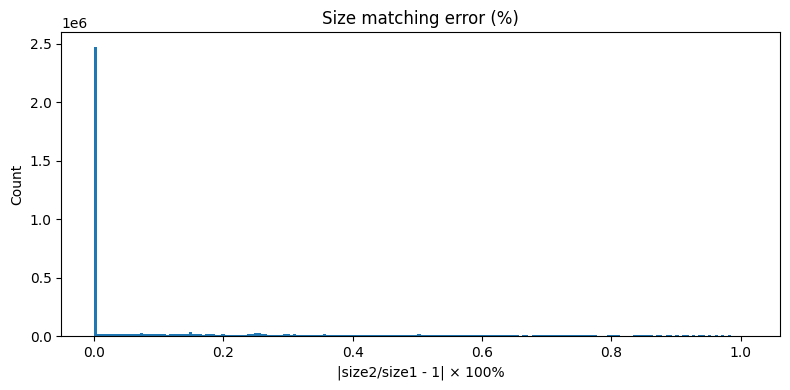

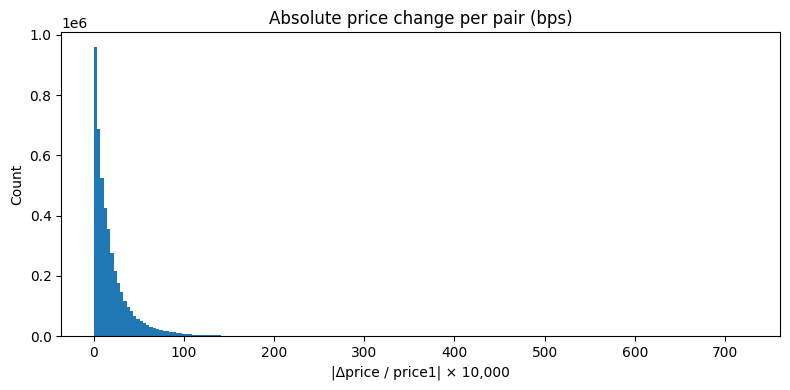

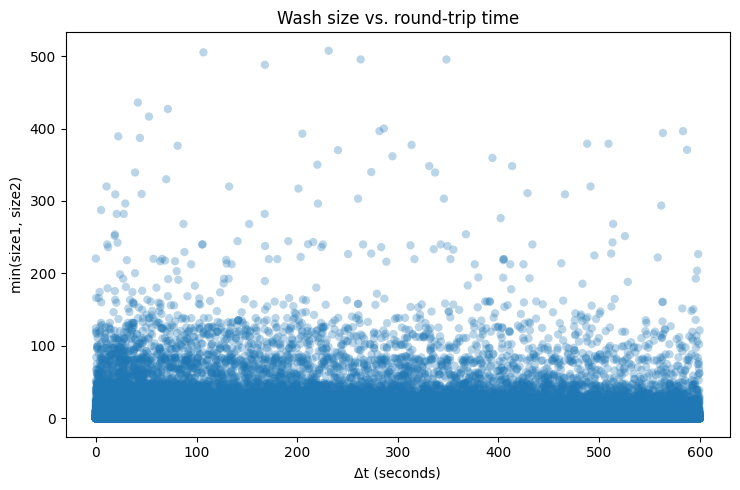

/tmp/ipykernel_8326/1475191110.py:157: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").sum().fillna(0).cumsum())


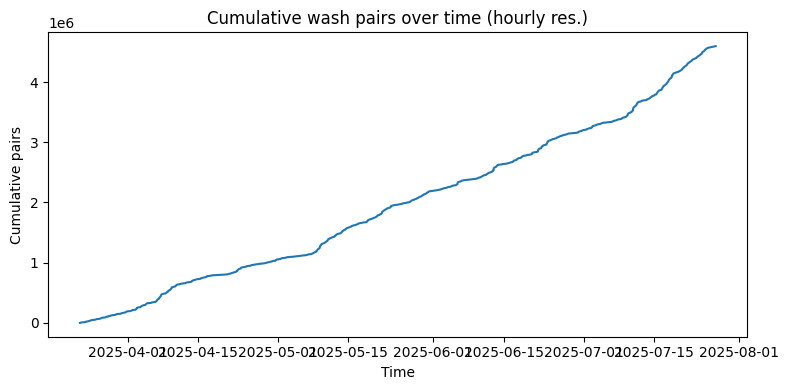

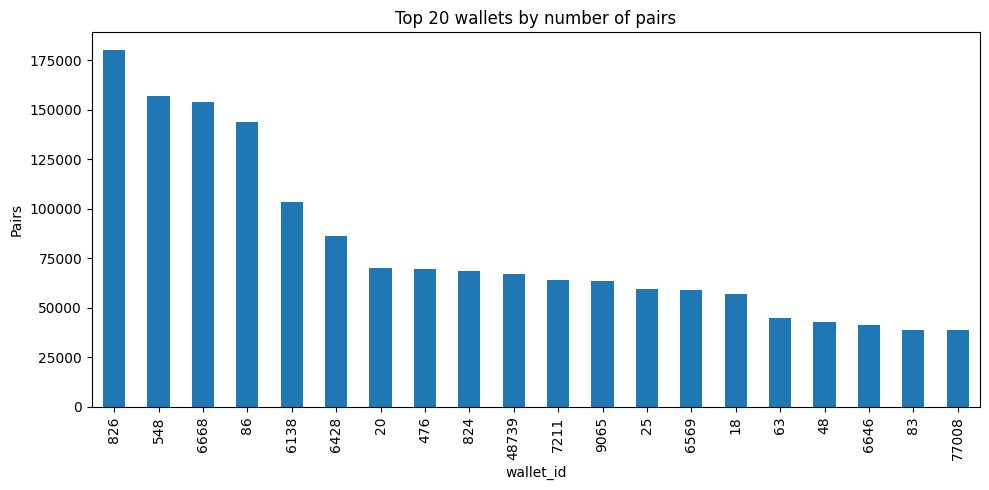

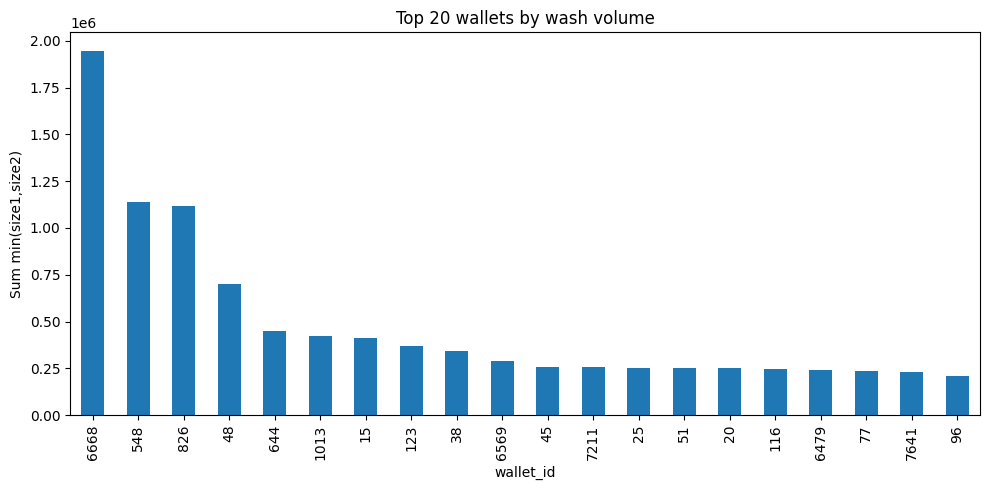

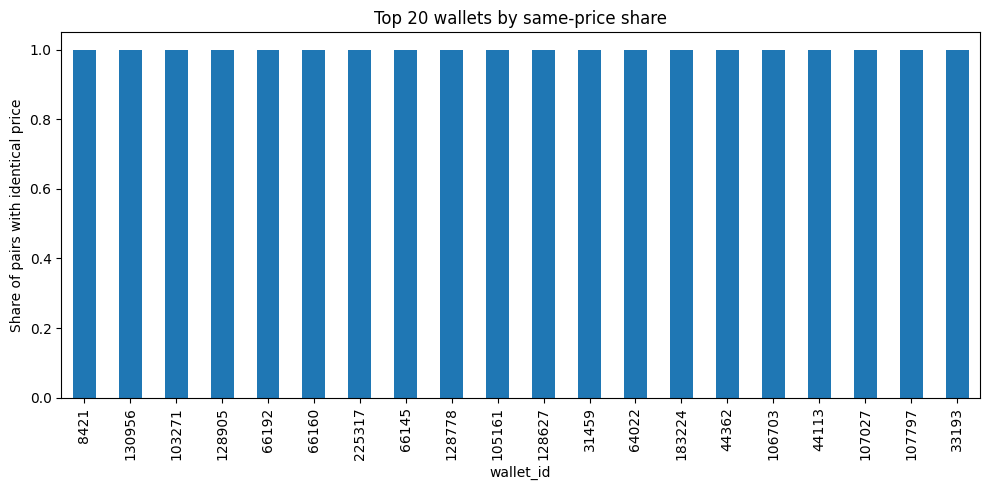

Saved plots to: /home/debian/Hyperliquid_Wash_Trading_detection/plots_dfwash_ETH


In [32]:
# If you have the DataFrame already:
make_dfwash_plots(DFWash, out_dir="plots_dfwash_ETH", show=True, top_wallets=25)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def _ensure_derived_cols(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if not np.issubdtype(d["t1"].dtype, np.datetime64):
        d["t1"] = pd.to_datetime(d["t1"], errors="coerce")
    d["wash_vol"] = np.minimum(d["size1"].astype("float64"), d["size2"].astype("float64"))
    d["mid_price"] = ((d["price1"].astype("float64") + d["price2"].astype("float64")) / 2.0)
    return d

def _bar_from_series(agg: pd.Series, title: str, ylabel: str,
                     out_dir=None, filename="plot.png", show=False, max_xticks=20):
    """
    Render a bar chart from a time-indexed Series agg.
    Uses categorical positions with thinned tick labels for readability.
    """
    x = np.arange(len(agg))
    y = agg.values

    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)

    # Thin xticks to at most max_xticks
    if len(x) > 0:
        step = max(1, len(x) // max_xticks)
        ax.set_xticks(x[::step])
        # format dates nicely if datetime index, else just str()
        if isinstance(agg.index, pd.DatetimeIndex):
            labels = [ts.strftime("%Y-%m-%d") for ts in agg.index[::step]]
        else:
            labels = [str(v) for v in agg.index[::step]]
        ax.set_xticklabels(labels, rotation=45, ha="right")

    plt.tight_layout()

    if out_dir:
        out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_dir / filename, dpi=150)
    if show:
        plt.show()
    plt.close()

def plot_wash_volume_by_date_bar(df: pd.DataFrame, freq: str = "D", out_dir=None, show=False):
    """
    Bar chart: sum of wash volume (min(size1,size2)) per date (or 'W'/'M').
    Also writes a CSV next to the PNG if out_dir is provided.
    """
    d = _ensure_derived_cols(df)
    s = pd.Series(d["wash_vol"].values, index=d["t1"])
    agg = s.resample(freq).sum().rename("wash_volume")

    if out_dir:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        agg.to_csv(Path(out_dir) / f"wash_volume_by_date_{freq}.csv")

    _bar_from_series(
        agg,
        title=f"Wash volume by date (freq={freq})",
        ylabel="Sum of min(size1, size2)",
        out_dir=out_dir,
        filename=f"wash_volume_by_date_{freq}.png",
        show=show,
    )

def plot_wash_notional_by_date_bar(df: pd.DataFrame, freq: str = "D", out_dir=None, show=False):
    """
    Bar chart: sum of wash notional per date (min(size1,size2) × mid price).
    Also writes a CSV next to the PNG if out_dir is provided.
    """
    d = _ensure_derived_cols(df)
    notional = (d["wash_vol"] * d["mid_price"]).rename("wash_notional")
    s = pd.Series(notional.values, index=d["t1"])
    agg = s.resample(freq).sum()

    if out_dir:
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        agg.to_csv(Path(out_dir) / f"wash_notional_by_date_{freq}.csv")

    _bar_from_series(
        agg,
        title=f"Wash notional (volume × price) by date (freq={freq})",
        ylabel="Sum of min(size) × mid_price",
        out_dir=out_dir,
        filename=f"wash_notional_by_date_{freq}.png",
        show=show,
    )

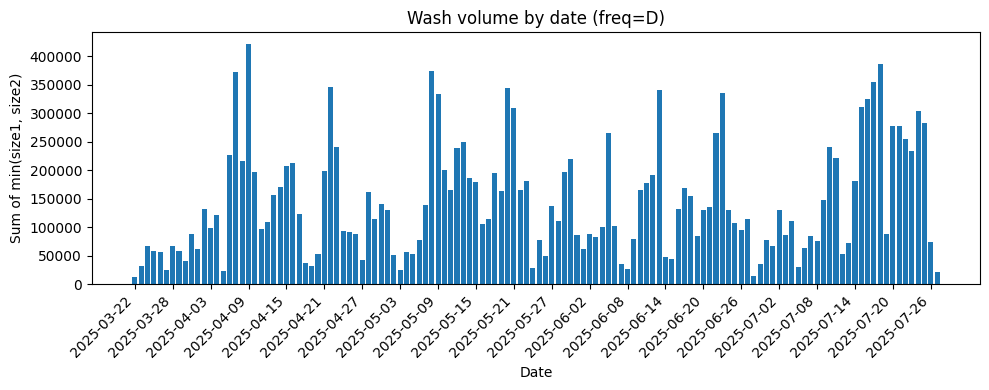

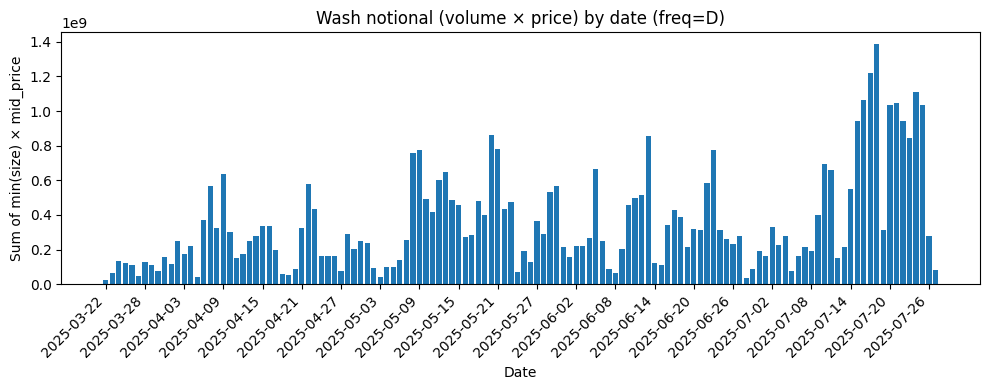

In [7]:
%matplotlib inline

# Daily bars
plot_wash_volume_by_date_bar(DFWash, freq="D", out_dir="plots_dfwash_ETH", show=True)
plot_wash_notional_by_date_bar(DFWash, freq="D", out_dir="plots_dfwash_ETH", show=True)

In [ ]:
DFWash["side1"].sum()

In [ ]:
print()